In [35]:
import numpy as np

# CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# MNIST
from keras.datasets import mnist

# plot
from matplotlib import pyplot as plt
%matplotlib inline  

from pathlib import Path

from PIL import Image

np.random.seed(123)  # for reproducibility

In [36]:
base_path = Path("data")
labels_path = base_path / "labels10k"
image_dirs = {
  "test": base_path / "teste",
  "train": base_path / "treinamento",
  "val": base_path / "validacao",
}

In [37]:
labels = {}
for label_file in labels_path.glob("*.txt"):
  with label_file.open("r") as file:
    labels[label_file.stem] = file.read().strip()

In [38]:
images = {key: [] for key in image_dirs}
for key, image_dir in image_dirs.items():
  images[key] = sorted(image_dir.glob("*.jpg"))

Labels (first 5): [('001953', '2RWRYW'), ('009192', 'BTC6AO'), ('008469', 'FQDU7M'), ('000304', 'QNV1HK'), ('004359', 'XP6QYA')]
Training images (first 5): [PosixPath('data/teste/009001.jpg'), PosixPath('data/teste/009002.jpg'), PosixPath('data/teste/009003.jpg'), PosixPath('data/teste/009004.jpg'), PosixPath('data/teste/009005.jpg')]


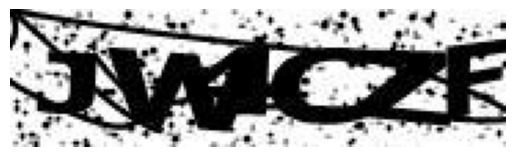

In [39]:
print("Labels (first 5):", list(labels.items())[:5])
print("Training images (first 5):", images["test"][:5])

image_path = images["test"][0]
image = Image.open(image_path)

# Display using matplotlib
plt.imshow(image)
plt.axis("off")  # Turn off axis labels
plt.show()

In [40]:
def split_image_into_subimages(image_path, num_splits=6, target_size=(28, 28)):
  image = Image.open(image_path)
  width, height = image.size
  sub_width = width // num_splits
  subimages = []

  for i in range(num_splits):
    left = i * sub_width
    right = (i + 1) * sub_width
    box = (left, 0, right, height)  # Crop region
    subimage = image.crop(box)
    subimage = subimage.convert("L")
    subimage = subimage.resize(target_size)  # Resize to target size
    subimages.append(np.array(subimage))  # Convert to NumPy array
  
  return subimages


In [41]:
digit_map = {str(i): i for i in range(10)}  # Mapping '0'-'9' to positions 0-9
letter_map = {chr(i): 10 + (i - ord('A')) for i in range(ord('A'), ord('Z') + 1)}  # Mapping 'A'-'Z' to positions 10-35

In [42]:
def encode_to_integer(label_part):
  """Converts a label part (digit or letter) into an integer representation."""
  if label_part.isdigit():
    return int(label_part)  # Return digit as integer
  elif label_part.isalpha():
    return ord(label_part.upper()) - ord('A') + 10  # Map 'A'-'Z' to 10-35
  return 0  # Default case, for robustness

In [43]:
def get_dataset(image_paths, labels):
  X = []
  y = []
  y_original = []

  for image_path in image_paths:
    # Extract the image ID (e.g., "000001" from "000001.jpg")
    image_id = image_path.stem

    # Skip if the label for this image ID is missing
    if image_id not in labels:
      continue

    # Get the label and split it into characters
    label = labels[image_id]
    label_parts = list(label)

    if (len(label) != 6):
      continue

    subimages = split_image_into_subimages(image_path, len(label))

    X.extend(subimages)  
    y.extend([encode_to_integer(part) for part in label_parts]) 
    y_original.extend(label_parts)

  return np.array(X), np.array(y), np.array(y_original)

In [44]:
X_train, y_train, y_original_train = get_dataset(images["train"], labels)
X_test, y_test, y_original_test = get_dataset(images["test"], labels)
X_val, y_val, y_original_val = get_dataset(images["val"], labels)

In [45]:
Y_train = to_categorical(y_train, 36)
Y_test = to_categorical(y_test, 36)
Y_val = to_categorical(y_val, 36)

In [46]:
print(Y_train.shape)
print(f'original class: {y_original_train[0]}')
print(f'class ID: {y_train[0]}')
print(f'Network ouptut: {Y_train[0][:]}')

(47982, 36)
original class: R
class ID: 27
Network ouptut: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


First three labels: ['R' 'N' 'I']


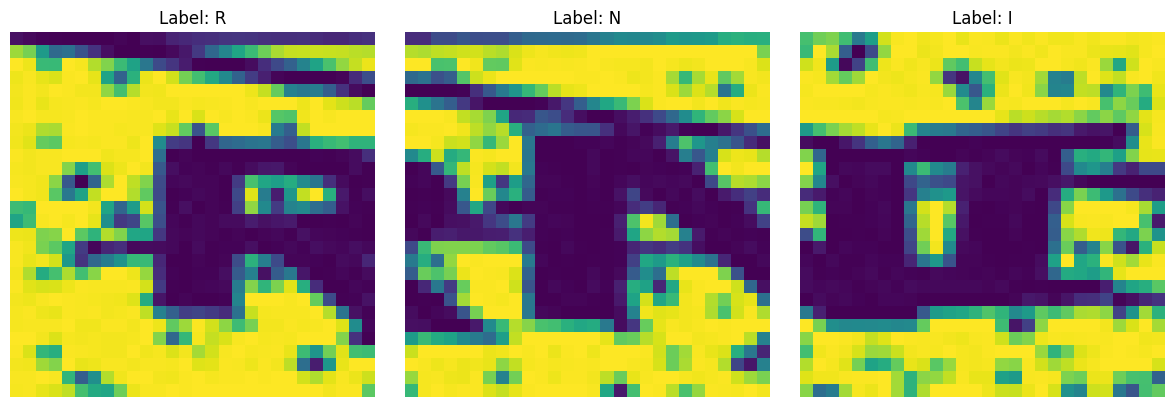

In [47]:
print("First three labels:", y_original_train[:3])

fig, axes = plt.subplots(1, 3, figsize=(12, 4)) 
for i in range(3):
  axes[i].imshow(X_train[i].astype("uint8"))  
  axes[i].axis("off")  
  axes[i].set_title(f"Label: {y_original_train[i]}") 

plt.tight_layout()
plt.show()


## Preprocess input data for Keras


In [48]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
X_train /= 255
X_test /= 255
X_val /= 255

## Preprocess class labels for Keras

In [49]:
Y_train = to_categorical(y_train, 36)
Y_test = to_categorical(y_test, 36)
Y_val = to_categorical(y_val, 36)

In [50]:
# Sequential layer
model = Sequential()

In [51]:
# CNN input layer
model.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu', padding='same', input_shape=(28,28,1)))

In [52]:
# hiden layers
model.add(Conv2D(32, (5, 5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model.add(Dropout(0.25))

In [53]:
# fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(36, activation='softmax'))

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1605888   
                                                      

In [55]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [56]:
print(X_train.shape)
print(Y_train.shape)

(47982, 28, 28)
(47982, 36)


In [57]:
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10,    
    restore_best_weights=True 
)

In [58]:
response = model.fit(
  X_train, Y_train, 
  validation_data=(X_val, Y_val),
  batch_size=128, 
  epochs=100, 
  verbose=1,
  callbacks=[early_stopping]
)

Epoch 1/100
375/375 [==============================] - 39s 101ms/step - loss: 1.9157 - accuracy: 0.4190 - val_loss: 0.5798 - val_accuracy: 0.8252
Epoch 2/100
375/375 [==============================] - 37s 98ms/step - loss: 0.7768 - accuracy: 0.7383 - val_loss: 0.3674 - val_accuracy: 0.8794
Epoch 3/100
375/375 [==============================] - 37s 98ms/step - loss: 0.5826 - accuracy: 0.8048 - val_loss: 0.2986 - val_accuracy: 0.9026
Epoch 4/100
375/375 [==============================] - 39s 104ms/step - loss: 0.4883 - accuracy: 0.8368 - val_loss: 0.2735 - val_accuracy: 0.9107
Epoch 5/100
375/375 [==============================] - 39s 104ms/step - loss: 0.4307 - accuracy: 0.8585 - val_loss: 0.2379 - val_accuracy: 0.9176
Epoch 6/100
375/375 [==============================] - 37s 99ms/step - loss: 0.3895 - accuracy: 0.8725 - val_loss: 0.2291 - val_accuracy: 0.9233
Epoch 7/100
375/375 [==============================] - 38s 100ms/step - loss: 0.3567 - accuracy: 0.8812 - val_loss: 0.2343 - va

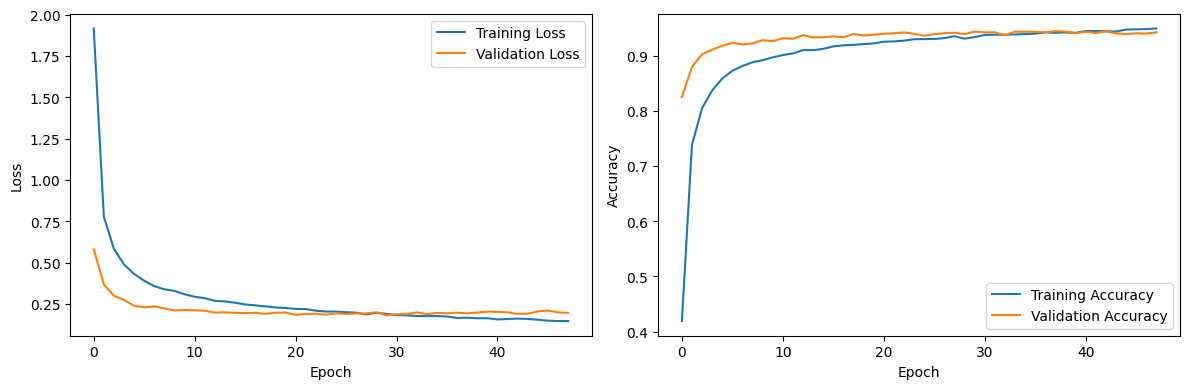

In [59]:
train_loss = response.history['loss']
train_accuracy = response.history['accuracy']
val_loss = response.history['val_loss']
val_accuracy = response.history['val_accuracy']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
score = model.evaluate(X_test, Y_test, verbose=1)

188/188 [==============================] - 1s 7ms/step - loss: 0.1910 - accuracy: 0.9438


In [61]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.1910303384065628, 0.9437770843505859]


In [62]:
print(X_test.shape)

(5994, 28, 28)


In [63]:
def evaluate_captcha_accuracy(model, X_test, y_test, captcha_length=6):
  """
  Evaluate the model's accuracy on entire CAPTCHAs.

  Args:
    model: Trained model for character recognition.
    X_test: Test dataset (images split into subimages).
    y_test: Test labels (one-hot encoded).
    captcha_length: Number of characters per CAPTCHA.

  Returns:
    accuracy_by_length: List of accuracies by the number of correct characters per CAPTCHA.
  """
  # Convert one-hot encoded labels back to characters
  def decode_label(one_hot_vector):
    index = np.argmax(one_hot_vector)
    if index < 10:
      return str(index)
    else:
      return chr(ord('A') + (index - 10))

  total_captchas = len(X_test) // captcha_length
  correct_captchas_by_length = [0] * (captcha_length + 1)

  for i in range(total_captchas):
    # Extract the subimages and ground truth for one CAPTCHA
    start_idx = i * captcha_length
    end_idx = start_idx + captcha_length
    subimages = X_test[start_idx:end_idx]
    true_labels = y_test[start_idx:end_idx]

    # Predict the labels for the subimages
    predictions = model.predict(subimages)
    predicted_labels = [decode_label(pred) for pred in predictions]

    # Decode true labels
    true_labels_decoded = [decode_label(true) for true in true_labels]

    # Count correct predictions for this CAPTCHA
    correct_count = sum(
      pred == true for pred, true in zip(predicted_labels, true_labels_decoded)
    )

    # Update statistics
    for j in range(correct_count+1):
      correct_captchas_by_length[j] += 1

  # Calculate accuracy by number of correct characters
  accuracy_by_length = [
    correct_captchas / total_captchas for correct_captchas in correct_captchas_by_length
  ]

  return accuracy_by_length

In [64]:
accuracy_by_length = evaluate_captcha_accuracy(model, X_test, Y_test)
for num_correct, accuracy in enumerate(accuracy_by_length):
    print(f"Accuracy for CAPTCHAs with {num_correct} correct characters: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 13ms/step
Accuracy for CAPTCHAs with 0 correct characters: 100.00%
Accuracy for CAPTCHAs with 1 correct characters: 100.00%
Accuracy for CAPTCHAs with 2 correct characters: 100.00%
Accuracy for CAPTCHAs with 3 correct characters: 100.00%
Accuracy for CAPTCHAs with 4 correct characters: 99.70%
Accuracy for CAPTCHAs with 5 correct characters: 95.30%
Accuracy for CAPTCHAs with 6 correct characters: 71.27%


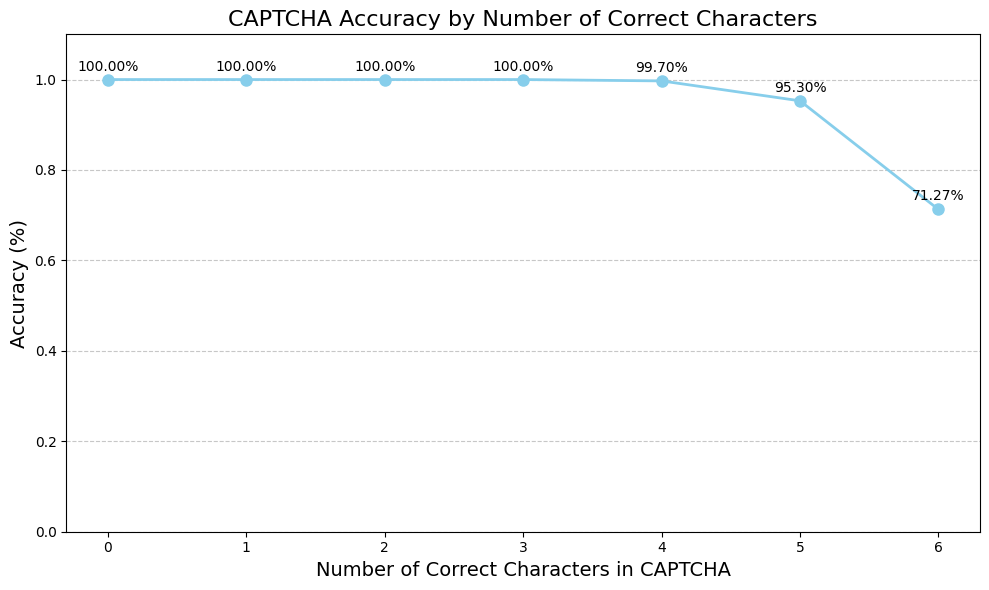

In [65]:
num_correct_chars = np.arange(len(accuracy_by_length))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(num_correct_chars, accuracy_by_length, marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)

# Add labels and title
plt.xlabel("Number of Correct Characters in CAPTCHA", fontsize=14)
plt.ylabel("Accuracy (%)", fontsize=14)
plt.title("CAPTCHA Accuracy by Number of Correct Characters", fontsize=16)

# Display percentage values next to points
for i, accuracy in enumerate(accuracy_by_length):
    plt.text(i, accuracy + 0.02, f"{accuracy * 100:.2f}%", ha='center', fontsize=10)

# Set y-axis to percentage
plt.ylim(0, 1.1)  # Accuracy is between 0 and 1; slightly above for text placement
plt.xticks(num_correct_chars)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [66]:
def get_captcha_recognition(image_path):
  subimages = split_image_into_subimages(image_path)
  subimages = np.array(subimages).astype('float32') / 255
  predictions = model.predict(subimages)
  predicted_labels = [np.argmax(pred) for pred in predictions]
  return "".join([chr(ord('A') + idx - 10) if idx >= 10 else str(idx) for idx in predicted_labels])

In [67]:
num_images = 3
predictions = []

for i in range(num_images):
  predictions.append(get_captcha_recognition(images['test'][i]))

1/1 [==============================] - 0s 14ms/step


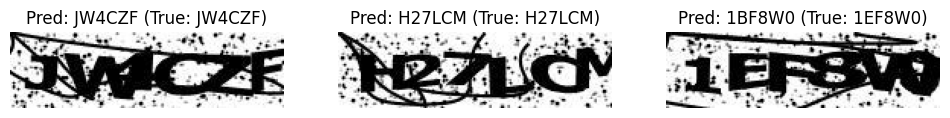

In [68]:
fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i in range(num_images):
  image = Image.open(images['test'][i])
  axes[i].imshow(image)
  axes[i].axis('off')
  axes[i].set_title(f"Pred: {predictions[i]} (True: {labels[images['test'][i].stem]})")